# Préparation de la base de données
<li> Entraînement sur 2 canaux d'entré : pondération T1 avec agent de constraste et Flair </li>

## Sources et références:


<p>https://www.kaggle.com/datasets/awsaf49/brats20-dataset-training-validation?resource=download</p>
<p>Data Usage Agreement / Citations:
You are free to use and/or refer to the BraTS datasets in your own research, provided that you always cite the following three manuscripts:

[1] B. H. Menze, A. Jakab, S. Bauer, J. Kalpathy-Cramer, K. Farahani, J. Kirby, et al. "The Multimodal Brain Tumor Image Segmentation Benchmark (BRATS)", IEEE Transactions on Medical Imaging 34(10), 1993-2024 (2015) DOI: 10.1109/TMI.2014.2377694

[2] S. Bakas, H. Akbari, A. Sotiras, M. Bilello, M. Rozycki, J.S. Kirby, et al., "Advancing The Cancer Genome Atlas glioma MRI collections with expert segmentation labels and radiomic features", Nature Scientific Data, 4:170117 (2017) DOI: 10.1038/sdata.2017.117

[3] S. Bakas, M. Reyes, A. Jakab, S. Bauer, M. Rempfler, A. Crimi, et al., "Identifying the Best Machine Learning Algorithms for Brain Tumor Segmentation, Progression Assessment, and Overall Survival Prediction in the BRATS Challenge", arXiv preprint arXiv:1811.02629 (2018) </p>

### Implémentation libre de droit utilisée et modifiée

<li>Auteur de l'implémentation : @author: Sreenivas Bhattiprolu </li>
<li>Code modifié passage de 3 canaux à 2 canaux </li>
<li>Variation de certains paramètres et fonctions utilisées </li>

## Description Dataset 


<p> Scans multimodals au format NIFI files (.nii.gz) et on dispose dans le DataSET BraTS de 4 cannaux d'informations (T1-weighted, T2-weighted, T1c, FLAIR). 
Nous utiliserons pour la détection uniquement T1-weighted contrasté et FLair. 
L'abscence de T1-weighted s'explique par sa redondance avec T1-weighted contrasté et de T2-weighted par l'impossibilité de le superposer dans le DataSet du BIM
</p>
<p>Annotation des pixels du masque par un chirurgien professionel: 
    <li> L0) Unlabeled volume == Gris </li>
    <li> L1) Necrotic and non-enhancing tumor core (NCR/NET) == orange</li>
    <li> L2) Peritumoral edema (ED) === jaune</li>
    <li> L3) No represented</li>
    <li> L4) GD-enhancing Tumor == rouge</li>
    
On réasigne le label 4 au label 3 </p>


<p> Le DataSet et composé de 369 patients. Ainsi pour chaque patient on doit  récuperer: 
<li>Le fichier T1-weighted </li>
<li>Le fichier FLAIR </li>
Les normaliser et les mettre au format Longeur*Largeur*profondeur*2 où le 2 représente ces deux canaux. </p>

## Préparation du  DataSet d'entrainement et de validation

### Modules nécessaires 

In [6]:
##### Importation des différents modules ########

import numpy as np
import nibabel as nib
import glob
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from tifffile import imsave
from sklearn.preprocessing import StandardScaler


### Test de la compréhension du dataset à travers un patient 

In [31]:
##### DEFINITION DU PATH ######
TRAIN_DATASET_PATH = '../../PYTHON/archive/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'

In [32]:
###### Chargement d'une image TEST FLAIR size (240 240 155)######
test_image_flair= nib.load(TRAIN_DATASET_PATH+'BraTS20_Training_001/BraTS20_Training_001_flair.nii').get_fdata()


#### Rescalling: Mise à l'échelle des images d'un même patient en terme de luminance

<p> Variation par rapport à l'implémentation utilisée pour suivre les conseils de normalisation des valeurs (Mooc de Stanford). L'opération centre les données autour de zéro: fonction de normalisation Z-score</p>

In [33]:
###### On importe la fonction de Standardisation Z-score ########
scaler=StandardScaler()

In [34]:
########## On affiche les caractéristiques avant modification ##########
print('maximum sans rescale : ' + str(test_image_flair.max()))
############ Nécessite de Rescale les values ########

# Obligé de rescale sur des volumes 1D d'ou on décompose en 1D puis on recompose en 3D
test_image_flair = scaler.fit_transform(test_image_flair.reshape(-1, test_image_flair.shape[-1])).reshape(test_image_flair.shape)

#On vérifie les modifications éffectuées 
print('maximum avec rescale : ' + str(test_image_flair.max()))

# Affichage des statistiques après la standardisation
print('moyenne: ' + str(test_image_flair.mean()))
print('écart type : ' + str(test_image_flair.std()))

maximum sans rescale : 625.0
maximum avec rescale : 73.06495157155447
moyenne: 3.122313240293487e-17
écart type : 0.933256525257412


In [44]:
####### Dans le cas d'un modèle à deux canal on applique cela que sur T1-weighted contrasté en plus ######
test_image_t1ce= nib.load(TRAIN_DATASET_PATH+'BraTS20_Training_001/BraTS20_Training_001_t1ce.nii').get_fdata()
test_image_t1ce = scaler.fit_transform(test_image_t1ce.reshape(-1, test_image_t1ce.shape[-1])).reshape(test_image_t1ce.shape)

#### Chargement du masque du patient 

In [45]:
######## On charge le Masque #########
test_image_mask= nib.load(TRAIN_DATASET_PATH+'BraTS20_Training_001/BraTS20_Training_001_seg.nii').get_fdata()
test_image_mask=test_image_mask.astype(np.uint8)
print(np.unique(test_image_mask))
test_image_mask[test_image_mask==4] = 3 ##LE LABEL 4 EST CHANGE EN 3
print(np.unique(test_image_mask))


[0 1 2 4]
[0 1 2 3]


In [46]:
import matplotlib.colors as mcolors

# Créez un dictionnaire qui associe chaque classe à une couleur spécifique
class_colors = {
    0: 'gray',   # Classe 0: Volume non labelisé - Gris
    1: 'red',     # Classe 1: Nécrose tumorale et corps non révelé (NCR/NET) - Rouge
    2: 'yellow',   # Classe 2: Oedème péritumoral (ED) - Jaune
    3: 'orange'       # Classe 3: Corps de la tumeur révelé par l'agent de contraste - Orange
}

#### Observation de la composition de la base de donnèes à travers un patient

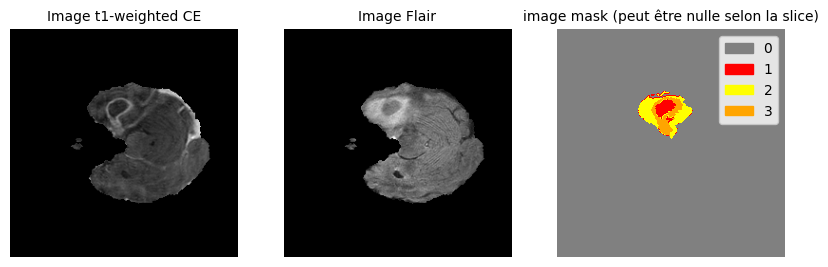

In [50]:
#### Choix d'une slice aléatoire ###
import random as rd
n_slice = rd.randint(0, test_image_mask.shape[2])


# Création d'une figure avec 1 ligne et 3 colonnes
fig, axs = plt.subplots(1, 3, figsize=(10, 5))


# Affichage de T1-WEIGHTED
axs[0].imshow(test_image_t1ce[:,:,n_slice], cmap='gray')
axs[0].axis('off')
axs[0].set_title("Image t1-weighted CE", fontsize=10)

# Affichage de FLAIR
axs[1].imshow(test_image_flair[:,:,n_slice], cmap='gray')
axs[1].axis('off')
axs[1].set_title("Image Flair", fontsize=10)



#Affichage du MASQUE
axs[2].imshow(test_image_mask[:, :, n_slice], cmap=mcolors.ListedColormap(list(class_colors.values())))
axs[2].axis('off')
axs[2].set_title("image mask (peut être nulle selon la slice)", fontsize=10)

# Créez une légende pour chaque classe
class_labels = ['Unlabeled volume', 'Necrotic and non-enhancing tumor core', 'Peritumoral edema', 'No represented', 'GD-enhancing Tumor']
legend_elements = [plt.Rectangle((0, 0), 1, 1, color=color, label=label) for label, color in class_colors.items()]
axs[2].legend(handles=legend_elements)

# Affichage du tableau avec les deux cellules
plt.show()

#### Principe du chanel combiné 


<li>On ne garde que 2 des 4 chanels possible comme dit en introduction  et on les combine pour avoir une image multichannel</li>
<li>Ce passage est potentiellement un point qui peut-étre amélioré avec un Unet à 3 canaux ou 4 cannaux</li>
<li>Puis nous enlevons les volumes vides (ici nous gardons le même paramètre que l'auteur modifiable par la suite)</li> 
<li>Les volumes sont alors des volumes 128*128*128 permettant d'appliquer des kernel de 64 ( puissance de 2 comme préconnisé MOOC Stanford ) et de réduire la zone mémoire nécessaire pour l'entraînement  </li>


In [52]:
### On combine en une image multichanel 
### Cela nous permet d'empiler les tableau selon la dimension anotée par axis ici 3
combined_x= np.stack([test_image_flair,test_image_t1ce], axis=3)

#### Rescale : On met à l'échelle le volume 3D

<p>Comme préconisé dans le Cours de Stanford le Stride de déplacement utilisé sera de 1 pour les opérations de convolution. Pour se faire nous avons besoin que nos entrée. Cette mise à l'échelle est permise par le faîte qu'une grande partie des images ont des coefficients nuls sur les bords du masque.</p>

In [53]:
### On concatenate les volumes vide
#On concatene en une taille divisible par 64 pour pouvoir ajouter le patch
#On obtient des images multi chanel en 128*128*128*2
combined_x=combined_x[56:184,56:184,13:141] 
test_image_mask_2=test_image_mask[56:184,56:184,13:141]

#### On doit maintenant observer des volumes en plus gros car on les a recentrés 

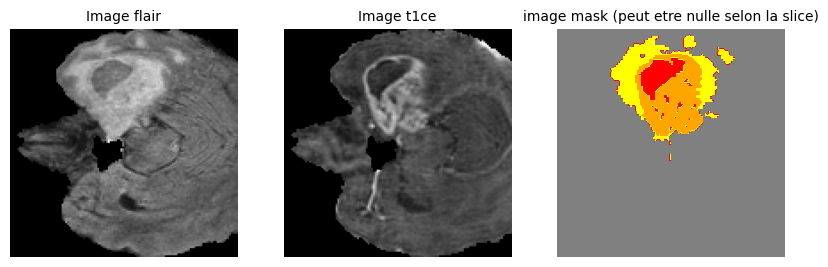

In [63]:
# On est obligé d'afficher une autre slice pour eviter un index out of range
n_slice = rd.randint(0, test_image_mask_2.shape[2])
#Nécessaireement cela ne sera plus la meme slice exactement

# Création d'une figure avec 2 ligne et 3 colonnes
fig, axs = plt.subplots(1, 3, figsize=(10, 5))

# Affichage de l'image flair
axs[0].imshow(combined_x[:,:,n_slice, 0], cmap='gray')
axs[0].axis('off')
axs[0].set_title("Image flair" ,fontsize=10)

# Affichage de l'image T1-WEIGHTED
axs[1].imshow(combined_x[:,:,n_slice, 1], cmap='gray')
axs[1].axis('off')
axs[1].set_title("Image t1ce", fontsize=10)


# Affichage du MASK
axs[2].imshow(test_image_mask_2[:,:,n_slice], cmap=mcolors.ListedColormap(list(class_colors.values())) )
axs[2].axis('off')
axs[2].set_title("image mask (peut etre nulle selon la slice)", fontsize=10)

# Affichage du tableau avec les deux cellules
plt.show()

##### Enregistrement des résultats

In [67]:
########### On sauvegarde nos résultats ###########################

imsave('../../PYTHON/archive/BraTS2020_TrainingData/combined355.tiff', combined_x) # Tiff file == multichanelfile
np.save('../../PYTHON/archive/BraTS2020_TrainingData/combined355.npy', combined_x) #So its not an image better  in numpy array

########## On vérifie que l'on arrive à les réouvrir à l'identique ######################
my_img=np.load('../../PYTHON/archive/BraTS2020_TrainingData/combined355.npy')
test_image_mask=to_categorical(test_image_mask, num_classes=4)
# Comparer les données chargées avec les données d'origine
are_equal = np.array_equal(combined_x, my_img)

print("Les données sont identiques :", are_equal)

/var/folders/kw/53sjlkps63vfp4455h6m9s6h0000gn/T/ipykernel_23189/3354232459.py:3: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  imsave('../../PYTHON/archive/BraTS2020_TrainingData/combined355.tiff', combined_x) # Tiff file == multichanelfile


Les données sont identiques : True


### Traitement de l'ensemble du DataSET
<li>On va définir les listes pour parcourrir toutes les slices T1 de chaque patients donc deux for </li>
<li>Méthode est de définir une liste pour t1 qui comporte tous les noms des fichiers t1 </li>
<li>Puis pour chaque stack d'image de patient on fait le traitement précédent</li>
<li>Ajout d'une Etape encore discutable qui vise à enlever les slices de mask si elle comporte peu d'information == pourcentage à discuter </li>


In [68]:
# Liste de 369 str == nom de tous les fichiers === chaque fichier contient les slices de un patient 
########## T1 CE list ############
t1ce_list=sorted(glob.glob('../../PYTHON/archive/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*t1ce.nii'))
########## FLAIR_LIST#########
flair_list=sorted(glob.glob('../../PYTHON/archive/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*flair.nii'))
########## MASK LIST #########
mask_list=sorted(glob.glob('../../PYTHON/archive/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*seg.nii'))

In [70]:
########## Pour chaque patient on fait le traitement de ses stack d'imges prédcédement réalisé ########

for patient in range(len(t1ce_list)):
    print('On prépare les stacks du patient: ' , patient)

    ##########On recupère pour chaque type de slice l'entiereté du stack que l'on reshape ##############


    tmp_image_t1ce=nib.load(t1ce_list[patient]).get_fdata()
    tmp_image_t1ce=scaler.fit_transform(tmp_image_t1ce.reshape(-1, tmp_image_t1ce.shape[-1])).reshape(tmp_image_t1ce.shape)

    tmp_image_flair=nib.load(flair_list[patient]).get_fdata()
    tmp_image_flair=scaler.fit_transform(tmp_image_flair.reshape(-1, tmp_image_flair.shape[-1])).reshape(tmp_image_flair.shape)

    tmp_image_mask=nib.load(mask_list[patient]).get_fdata()
    tmp_image_mask=tmp_image_mask.astype(np.uint8)
    tmp_image_mask[tmp_image_mask==4] = 3
    
    
    ###########On crée notre fichier multi-chanel pour chaque patient ########################
    tmp_combined_patient= np.stack([tmp_image_flair, tmp_image_t1ce], axis=3)
    
    ### On concatenate les volumes vide en un multiple de 32
    tmp_combined_patient=tmp_combined_patient[56:184,56:184,13:141] #On obtient des images multi chanel en 128*128*128*3
    tmp_image_mask=tmp_image_mask[56:184,56:184,13:141]


    ################ Partie du code QUI VA CHANGER ##################
    #######On selectionne uniquement les slices de mask comportant plus d'un certain pourcentage d'informations
    #Ce pourcentage a été gardé par défault et est issue du code open-source axe de changement/amélioration
    #Pour tout le volume présent dans le masque on va compter le nombre de fois ou un pixel est indéxé 0, 1, 2 ou 3 
    # On récupère alors des listes associées
    val, counts = np.unique(tmp_image_mask, return_counts=True)

    #Si le volume à moins de 1 pourcent d'interet alors on ne le garde pas 
    if (1-(counts[0]/counts.sum()))> 0.01:
        print("Save ME")
        tmp_image_mask=to_categorical(tmp_image_mask, num_classes=4)
        np.save('../../PYTHON/archive/BraTS2020_TrainingData/input_data_2channels/images/patient_'+str(patient)+'.npy', tmp_combined_patient)
        np.save('../../PYTHON/archive/BraTS2020_TrainingData/input_data_2channels/masks/patient_'+str(patient)+'.npy', tmp_image_mask)
        
    else:
        print('Im useless')
    
    

On prépare les stacks du patient:  0
Save ME
On prépare les stacks du patient:  1
Save ME
On prépare les stacks du patient:  2
Save ME
On prépare les stacks du patient:  3
Save ME
On prépare les stacks du patient:  4
Im useless
On prépare les stacks du patient:  5
Save ME
On prépare les stacks du patient:  6
Save ME
On prépare les stacks du patient:  7
Save ME
On prépare les stacks du patient:  8
Save ME
On prépare les stacks du patient:  9
Save ME
On prépare les stacks du patient:  10
Save ME
On prépare les stacks du patient:  11
Save ME
On prépare les stacks du patient:  12
Save ME
On prépare les stacks du patient:  13
Save ME
On prépare les stacks du patient:  14
Save ME
On prépare les stacks du patient:  15
Save ME
On prépare les stacks du patient:  16
Save ME
On prépare les stacks du patient:  17
Save ME
On prépare les stacks du patient:  18
Save ME
On prépare les stacks du patient:  19
Save ME
On prépare les stacks du patient:  20
Save ME
On prépare les stacks du patient:  21
Sav

#### On va vérifier ici que les images ont été enregistrer dans le meme ordre 

In [72]:
import os
train_img_dir = "../../PYTHON/archive/BraTS2020_TrainingData/input_data_2channels/images/"
train_mask_dir = "../../PYTHON/archive/BraTS2020_TrainingData/input_data_2channels/masks/"
img_list_recup = [file for file in os.listdir(train_img_dir) if not file.startswith('.DS_Store')] # présence d'un fichier étrange 
msk_list_recup = os.listdir(train_mask_dir)

In [73]:
print(len(img_list_recup) == len(msk_list_recup))

for i in range (len(img_list_recup)):
    if img_list_recup[i] != msk_list_recup[i]:
        print("le patient " , i ," est problématique" )
    

True


### On sépare notre dossier d'entrainement en deux parties une pour l'entrainement et une autres pour les mesures de précision à chaque epoch. 

In [77]:
import splitfolders

input_folder= '../../PYTHON/archive/BraTS2020_TrainingData/input_data_2channels'
output_folder='../../PYTHON/archive/BraTS2020_TrainingData/input_data_128_2channels'

########### On coservera 80% des images pour l'entrainement et 20% pour la validation

splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(.80, .20),group_prefix=None)